In [1]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric --no-index --find-links=file:///kaggle/input/torch-geometric

Looking in links: file:///kaggle/input/torch-geometric
Processing /kaggle/input/torch-geometric/torch_scatter-2.0.9-cp37-cp37m-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_sparse-0.6.13-cp37-cp37m-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_cluster-1.6.0-cp37-cp37m-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_spline_conv-1.2.1-cp37-cp37m-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_geometric-2.0.4-py3-none-any.whl


In [2]:
import torch
from torch_geometric.datasets import GNNBenchmarkDataset
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.loader import DataLoader
import torch_geometric
from typing import List, Any
import torchmetrics
import pytorch_lightning as pl
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
ds_train = GNNBenchmarkDataset(root="./", name="MNIST", split="train")
ds_test = GNNBenchmarkDataset(root="./", name="MNIST", split="test")
ds_val = GNNBenchmarkDataset(root="./", name="MNIST", split="val")

Extracting ./MNIST/raw/MNIST_v2.zip
Processing...
Done!


# Part a Visualizing MNIST Graphs

In [4]:
# With special thanks to Yannik for the visualization code :)

def get_pos_dict(pos):
    dict = {}
    for i in range(len(pos)):
        dict[i]= (pos[i][0], pos[i][1])
    return dict

def get_node_color(x):
    return list(map(lambda s: s[0].item(), x)) 

def get_edge_color(x):
    return list(map(lambda s: float(s), x))

def visualize(data, cmap=plt.cm.bwr):
    plt.figure(figsize=(15, 15))
    data = data.cpu()
    plt.title(f"Graph for: {data.y.item()}")
    g = torch_geometric.utils.to_networkx(data, to_undirected=False)
    nx.draw_networkx(
        g,
        get_pos_dict(data.pos),
        cmap=cmap, 
        edge_cmap=cmap, 
        with_labels=True,
        width=2,
        font_color="w", 
        font_size=14, 
        node_size=400,
        node_color=get_node_color(data.x), 
        edge_color=get_edge_color(data.edge_attr)
    )

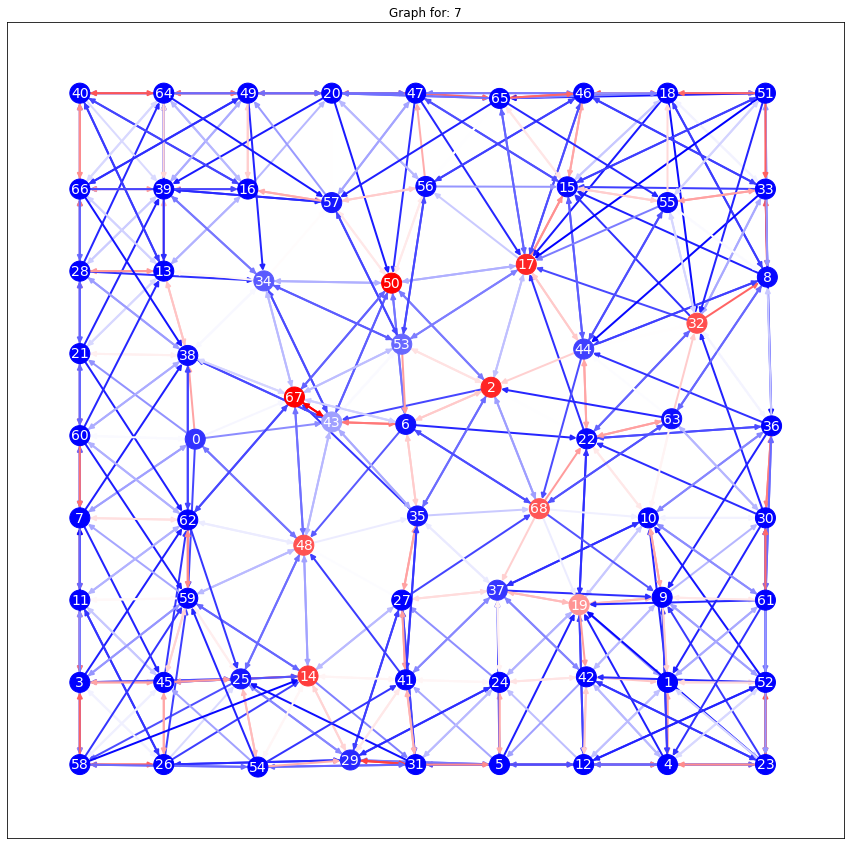

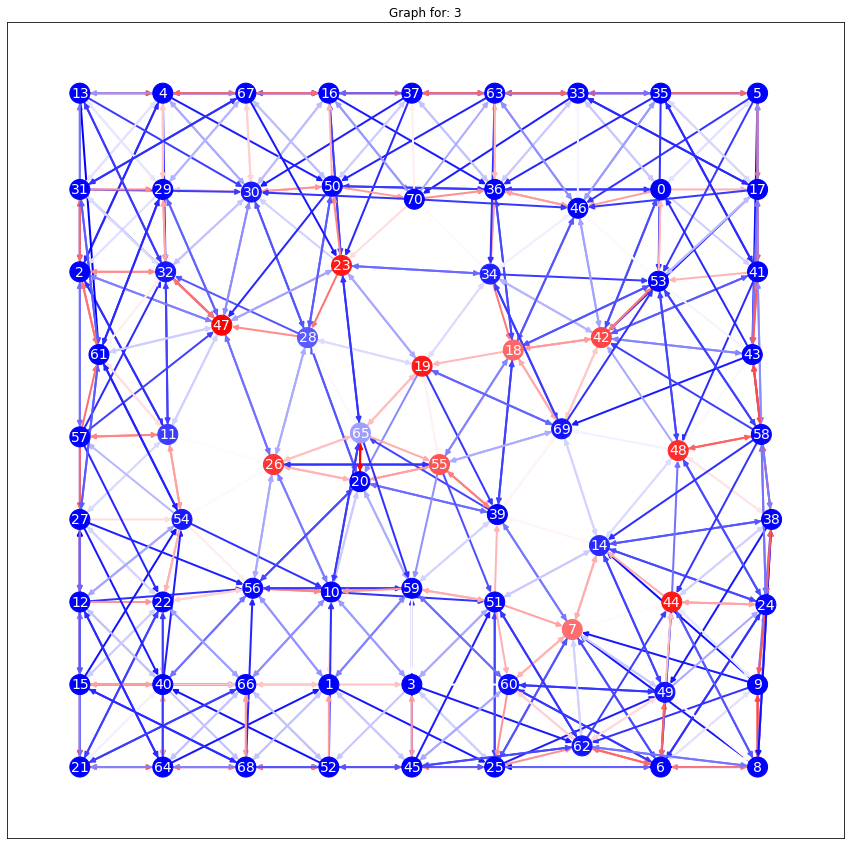

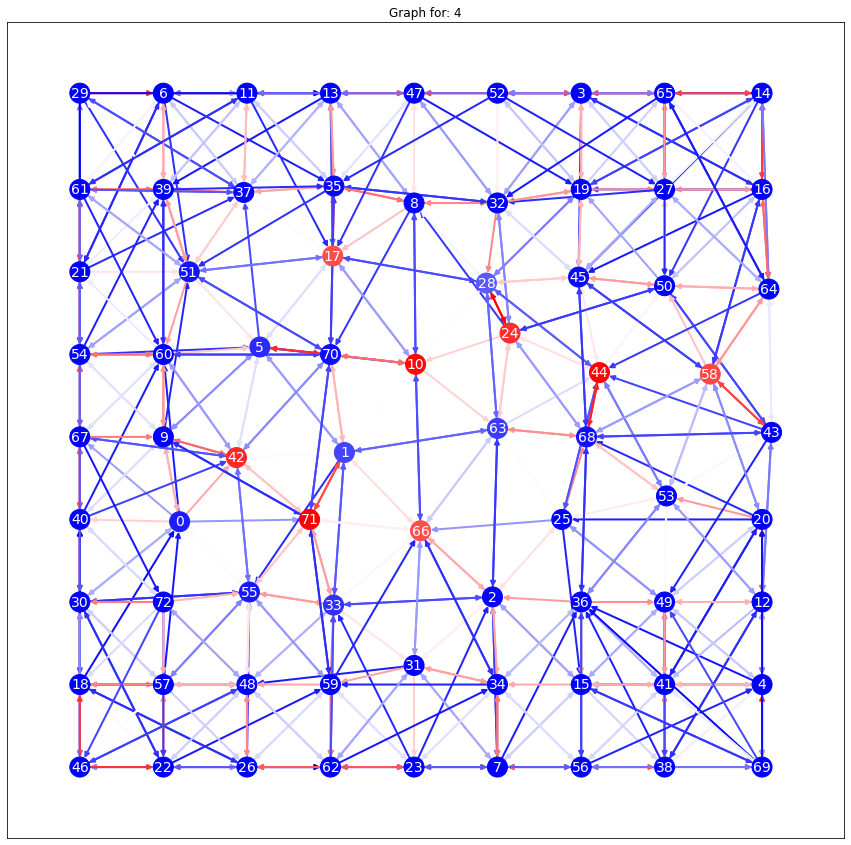

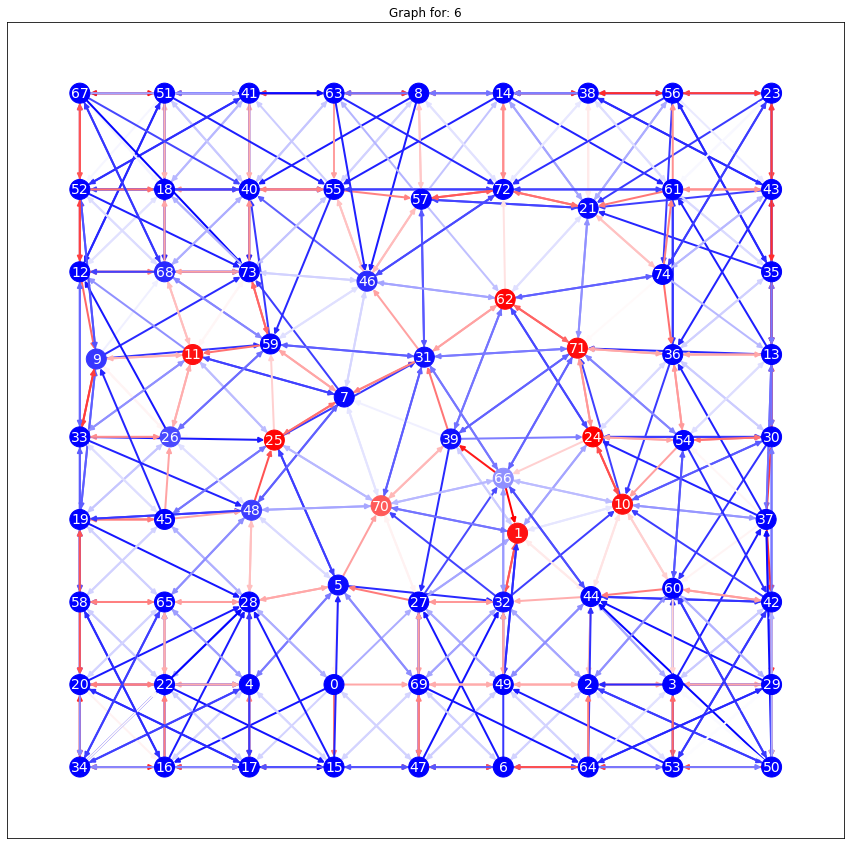

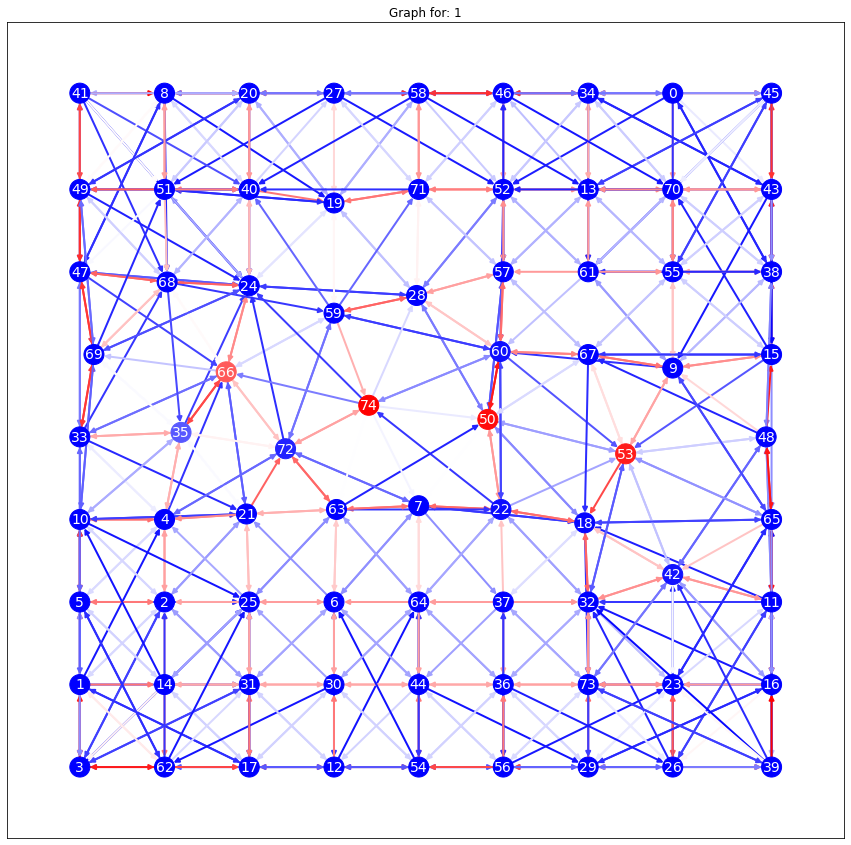

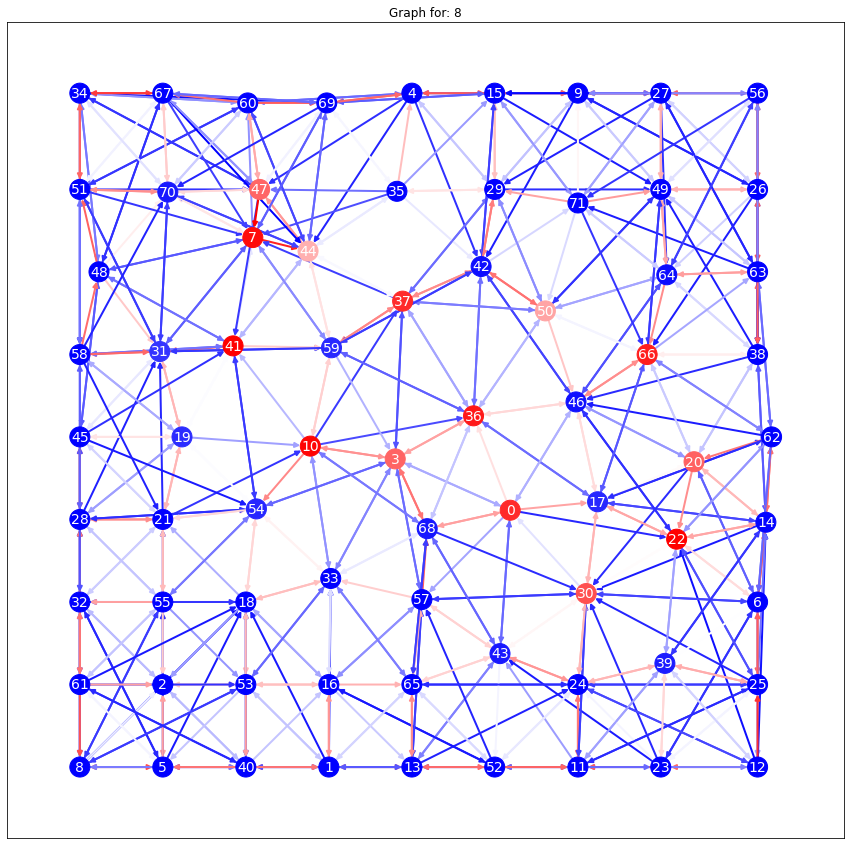

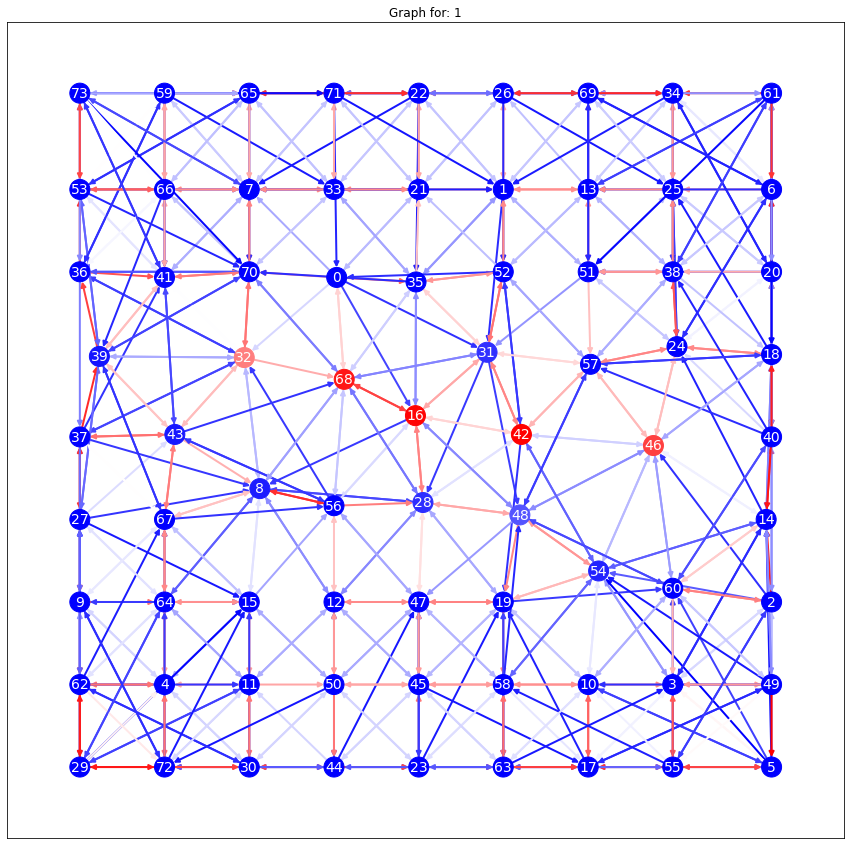

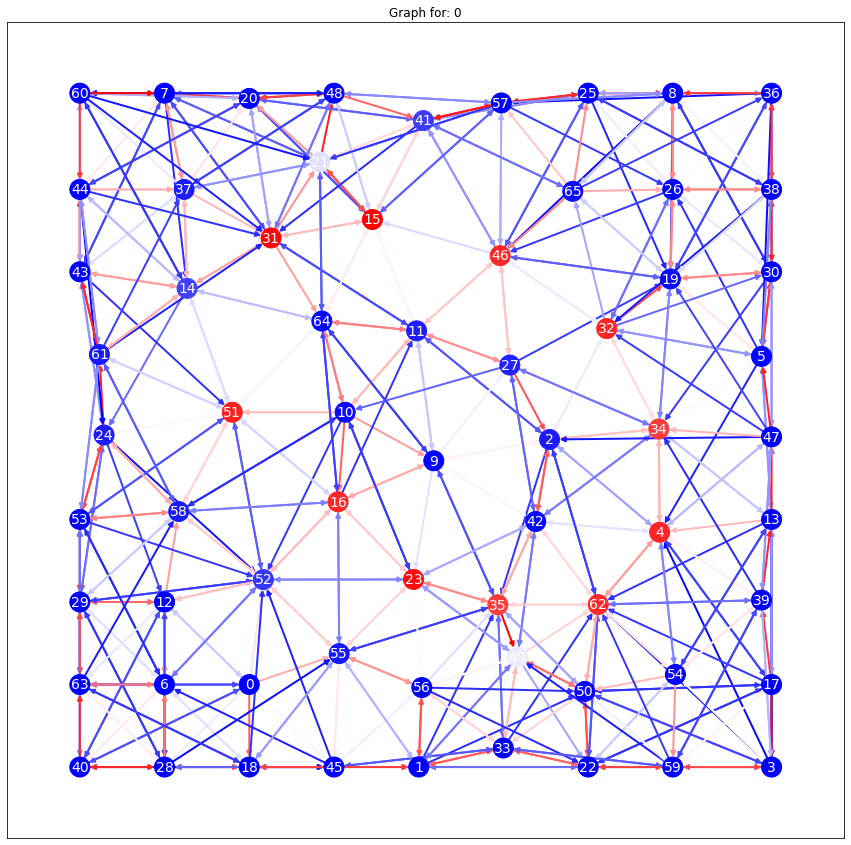

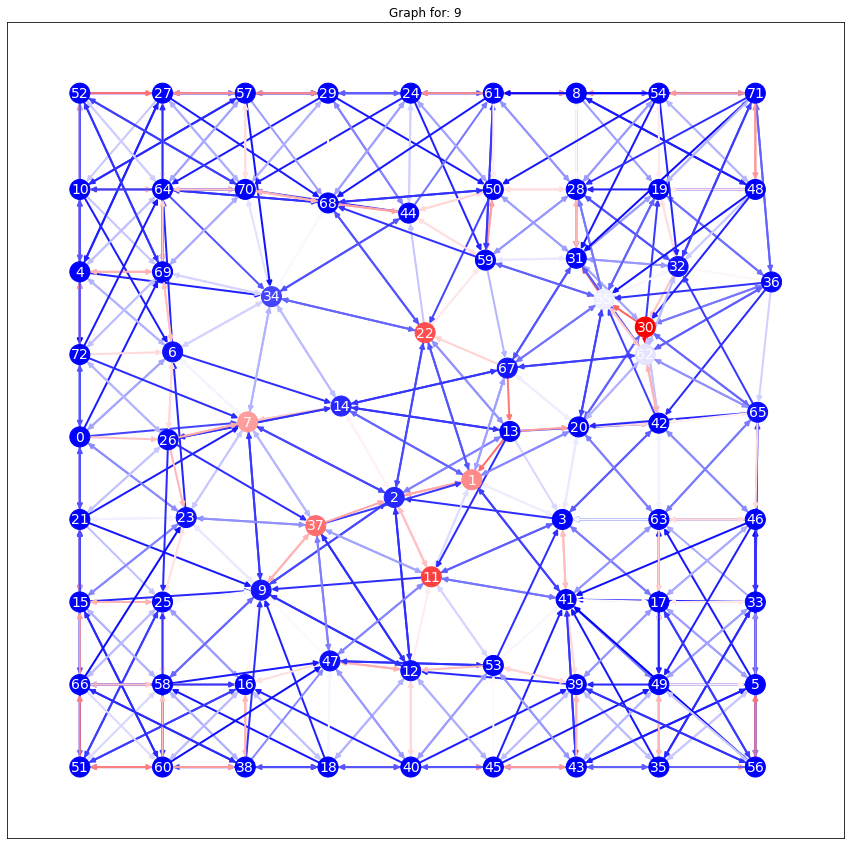

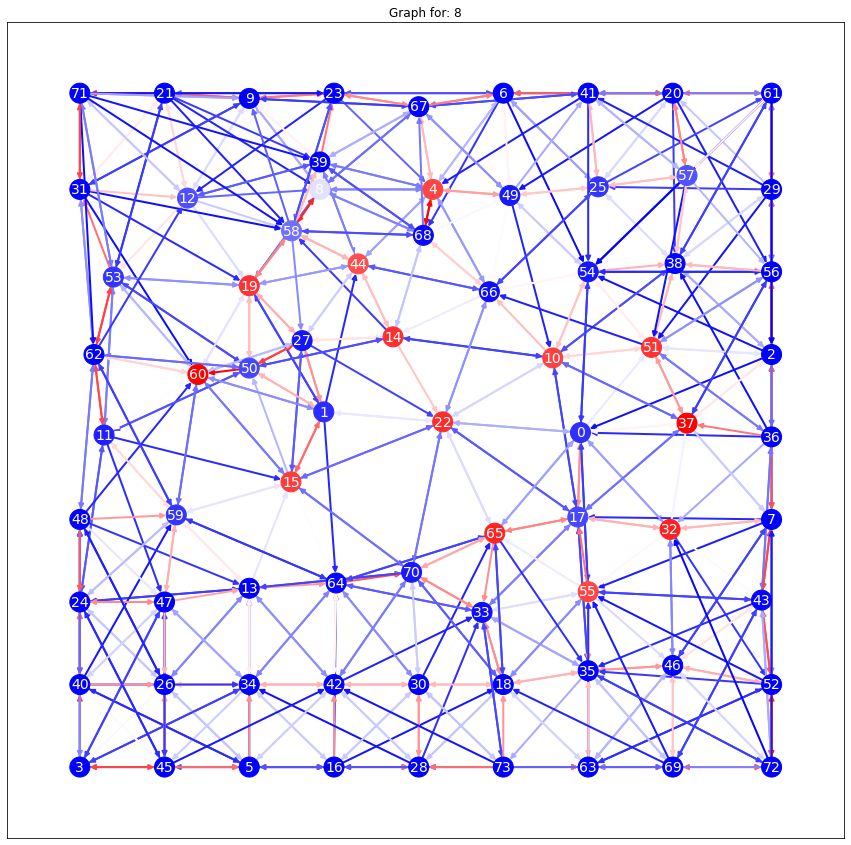

In [5]:
for i in range(10):
    sample = ds_train[i]
    visualize(sample)

# Part b)

## Train Models and Report Accuracy

1. Define Models
2. Define DataLoaders
3. Test

In [6]:
from torch_geometric.nn import global_mean_pool, global_max_pool

class GNNWrapper(pl.LightningModule):

    def __init__(self, 
        loss: callable, 
        lr: float,
        model: torch.nn.Module,
        val_metrics: List[torchmetrics.Metric],
        test_metrics: List[torchmetrics.Metric]
    ) -> None:
        super().__init__()

        self.loss = loss
        self.lr = lr
        
        self.model = model
        
        # eval stuff
        self.test_metrics = test_metrics
        self.val_metrics = val_metrics
        
    def forward(self, x, edge_index, batch_index) -> torch.Tensor:
        out = self.model(x, edge_index, batch_index)
        return out

    def _step(self, batch) -> torch.Tensor:
        x, edge_index, batch_index, y = batch.x, batch.edge_index, batch.batch, batch.y
        pred  = self.forward(x, edge_index, batch_index)
        loss = self.loss(pred, y)
        return pred, loss

    def training_step(self, batch) -> torch.Tensor:
        pred, loss = self._step(batch)
        self.log("train/loss", loss)
        return loss
    
    def _eval_step(self, batch, metrics):
        pred, loss = self._step(batch)
        for metric in metrics:
            metric.to(self.device)
            metric.update(pred, batch.y)

        return loss

    def _eval_epoch_end(self, eval_type, metrics):
        for metric in metrics:
            value = metric.compute().detach().data
            self.log(f"{eval_type}/{metric.__class__.__name__}:", value)
            print(f"{eval_type} {metric.__class__.__name__}: {value}")
        
    def test_step(self, batch: torch.Tensor, idx) -> torch.Tensor:
        loss = self._eval_step(batch, self.test_metrics)

    def test_epoch_end(self, outputs) -> None:
        self._eval_epoch_end("Test", self.test_metrics)

    def validation_step(self, batch: torch.Tensor, batch_idx: int) -> torch.Tensor:
        loss = self._eval_step(batch, self.val_metrics)

    def validation_epoch_end(self, outputs) -> None:
        self._eval_epoch_end("Val",  self.val_metrics)
                
    def configure_optimizers(self) -> Any:
        optim = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optim


In [7]:
class CustomGNN(torch.nn.Module):
    def __init__(self, embedding_size, num_classes, num_features):
        # Init parent
        super().__init__()
        torch.manual_seed(42)
        # GCN layers
        k=8
        self.model = torch_geometric.nn.Sequential('x, edge_index, batch', [
            (torch_geometric.nn.ChebConv(num_features, embedding_size, k), 'x, edge_index -> x1'),
            torch.nn.ReLU(),
            torch_geometric.nn.BatchNorm(embedding_size),
            (torch_geometric.nn.ChebConv(embedding_size, embedding_size, k), 'x1, edge_index -> x2'),
            torch.nn.ReLU(),
            torch_geometric.nn.BatchNorm(embedding_size),            
            (torch_geometric.nn.ChebConv(embedding_size, embedding_size, k), 'x2, edge_index -> x2'),
            torch.nn.ReLU(),
            torch_geometric.nn.BatchNorm(embedding_size),
            (lambda x1, x2: [x1, x2], 'x1, x2 -> xs'),
            (torch_geometric.nn.JumpingKnowledge("cat", embedding_size), 'xs -> x'),   
            (torch_geometric.nn.ChebConv(embedding_size * 2, embedding_size, k), 'x, edge_index -> x1'),
            torch.nn.ReLU(),
            torch_geometric.nn.BatchNorm(embedding_size),
            (torch_geometric.nn.ChebConv(embedding_size, embedding_size, k), 'x1, edge_index -> x2'),
            torch.nn.ReLU(),
            torch_geometric.nn.BatchNorm(embedding_size),
            (torch_geometric.nn.ChebConv(embedding_size, embedding_size, embedding_size), 'x2, edge_index -> x2'),
            torch.nn.ReLU(),
            torch_geometric.nn.BatchNorm(embedding_size),
            (lambda x1, x2: [x1, x2], 'x1, x2 -> xs'),
            (torch_geometric.nn.JumpingKnowledge("cat", embedding_size), 'xs -> x'),
            (torch_geometric.nn.ChebConv(2 * embedding_size, 16, k), 'x, edge_index -> x1'),
            torch.nn.ReLU(),
            torch_geometric.nn.BatchNorm(16),
            (torch_geometric.nn.ChebConv(16, 16, k), 'x1, edge_index -> x2'),
            torch.nn.ReLU(),
            torch_geometric.nn.BatchNorm(16),
            (torch_geometric.nn.ChebConv(16, 16, k), 'x2, edge_index -> x2'),
            torch.nn.ReLU(),
            torch_geometric.nn.BatchNorm(16),  
            (lambda x1, x2: [x1, x2], 'x1, x2 -> xs'),
            (torch_geometric.nn.JumpingKnowledge("cat", 16), 'xs -> x'),
            (torch_geometric.nn.global_mean_pool, 'x, batch -> x_mean'),
            #(torch_geometric.nn.global_max_pool, 'x, batch -> x_max'),
            torch.nn.Linear(embedding_size, num_classes)
        ])
        
    def forward(self, x, edge_index, batch):
        out = self.model(x, edge_index, batch)
        return out

In [8]:
# Instantiate the GNN's

embedding_size = 32
node_features = ds_train.num_node_features
num_classes = ds_train.num_classes
loss = torch.nn.functional.nll_loss
lr = 0.0007
epochs = 15
log_intervall = 5
val_intervall = 2
batch_size = 2048

dl_train = DataLoader(dataset=ds_train, batch_size=batch_size, shuffle=True, num_workers=2)
dl_test = DataLoader(dataset=ds_test, batch_size=batch_size, shuffle=False)
dl_val = DataLoader(dataset=ds_val, batch_size=batch_size, shuffle=False)


model = CustomGNN(embedding_size, num_classes, node_features)
# Define the metrics
test_metrics = [torchmetrics.Accuracy(num_classes), torchmetrics.AUROC(num_classes)]
val_metrics = [torchmetrics.Accuracy(num_classes), ]

convolution_model = GNNWrapper(
    loss=loss, 
    lr=lr, 
    model=model, 
    val_metrics=val_metrics, 
    test_metrics=test_metrics
)


/opt/conda/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [9]:
trainer = pl.Trainer(max_epochs=epochs, accelerator="gpu", devices=1, log_every_n_steps=log_intervall, check_val_every_n_epoch=val_intervall)
trainer.fit(convolution_model, dl_train, val_dataloaders=[dl_val])

Sanity Checking: 0it [00:00, ?it/s]

Val Accuracy: 0.09130859375


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Val Accuracy: 0.1567722111940384


Validation: 0it [00:00, ?it/s]

Val Accuracy: 0.22410613298416138


Validation: 0it [00:00, ?it/s]

Val Accuracy: 0.2706325948238373


Validation: 0it [00:00, ?it/s]

Val Accuracy: 0.30930444598197937


Validation: 0it [00:00, ?it/s]

Val Accuracy: 0.3375721871852875


Validation: 0it [00:00, ?it/s]

Val Accuracy: 0.3600129187107086


Validation: 0it [00:00, ?it/s]

Val Accuracy: 0.37502557039260864


In [10]:
trainer.test(convolution_model, dl_test)

Testing: 0it [00:00, ?it/s]

Test Accuracy: 0.4887999892234802
Test AUROC: 0.8517684936523438


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        Test/AUROC:        │    0.8517684936523438     │
│      Test/Accuracy:       │    0.4887999892234802     │
└───────────────────────────┴───────────────────────────┘

[{'Test/Accuracy:': 0.4887999892234802, 'Test/AUROC:': 0.8517684936523438}]